In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

***Extract excel file(csv) into manipulatable format(pandas)***

In [ ]:
points_path = '/content/2022 Case challenge_ DA update.xlsx - Data. Loyalty Points.csv'
loyal_benefits_path = '/content/2022 Case challenge_ DA update.xlsx - Data. Loyalty benefits.csv'
trans_path = '/content/2022 Case challenge_ DA update.xlsx - Data. Transactions.csv'
merchant_path = '/content/2022 Case challenge_ DA update.xlsx - Data.Merchant.csv'

In [ ]:
points = pd.read_csv(points_path)
benefits = pd.read_csv(loyal_benefits_path)
trans = pd.read_csv(trans_path)
merchant = pd.read_csv(merchant_path)

Modify columns name to no-spaces for the ease of query 

In [ ]:
for df in [points,trans,merchant]:
  df.rename(columns = {'Service Group': 'service_group'},inplace = True) 

In [ ]:
points.rename(columns={'Point Mechanism':'point_mechanism', 'Maximum Point Per Trans':'max_point_per_trans'}, inplace=True)

Modify point_mechanism column to get point/GMV

In [ ]:
point_pos = len(points.iloc[0,1]) - 1 #Get points per GMV's position in the string, if total length = 19 => the position will -19 to 0(from 0 to 0)
points['point_mechanism'] = points['point_mechanism'].apply(lambda x: x[:-point_pos]) #Modify the column to get the point/GMV by cutting the redundant string
points.head()

,service_group,point_mechanism,max_point_per_trans
0,supermarket,1,500 points
1,data,10,1000 points
2,cvs,1,300 points
3,marketplace,1,500 points
4,Coffee chains and Milk tea,1,500 points


Modify max points per trans columns to usable format

In [ ]:
points['point_mechanism'] = points['point_mechanism'].astype(int)

In [ ]:
points['max_point_per_trans'] = points['max_point_per_trans'].apply(lambda x: x[:-7]).astype(int)

#**Part 1: Data Processing**



1/ Combined with the 'Loyalty Points' table, add a column 'Loyalty Points' in 'Transactions' table with given rules. Then create another table named 'Loyalty Ranking' which must includes columns named Rank_name and Calculated_points to calculate the Rank of each user on daily basic. At the end of Mar 2022, how many user achived rank Gold? 																									

**Rules dataframe**

In [ ]:
rules_dict = {
    'classID':[1,2,3,4],
    'rank_name':['STANDARD','SILVER','GOLD','DIAMOND'],
    'loyalty_points':[1000,2000,5000,float('inf')]
}
rules = pd.DataFrame(rules_dict)
rules

,classID,rank_name,loyalty_points
0,1,STANDARD,1000.0
1,2,SILVER,2000.0
2,3,GOLD,5000.0
3,4,DIAMOND,inf


- Initiate a transaction table deep copy for the ease of testing and backing-up
- Get only data since the "Momo Hoàn Tiền" program launched - Jan 1st 2022
- Get total point per user


In [ ]:
#parse date into datetime format
trans['DATE'] = pd.to_datetime(trans['DATE'])
#filter out data history that took place before the launched date
new_trans = trans[trans.DATE > '2021-12-31'].reset_index().drop(['index'],axis = 1)
new_trans.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,service_group
0,2022-01-01,19502954801,Supermarket,25,45715492,41400,supermarket
1,2022-01-01,19492487660,CVS,28,41720789,205000,cvs
2,2022-01-01,19491373621,CVS,28,55200938,237000,cvs
3,2022-01-01,19485025779,CVS,28,17144057,17000,cvs
4,2022-01-01,19497349350,Marketplace,37,46410460,340000,marketplace


Check if there's any null value

Dropped duplicated data

In [ ]:
new_trans.drop_duplicates(inplace=True,ignore_index=True)

Create function to calculate point from GMV and service group respectively

In [ ]:
#Convert to point based on the points table
def to_point(x):
  service_group, gmv = x[-1], x[-2]
  cur_category = points[points['service_group'] == service_group]
  point = cur_category.iloc[0,1] * gmv / 1000
  if point > cur_category.iloc[0,2]:
    point = cur_category.iloc[0,2]
  return point



---



In [ ]:
new_trans['point'] = new_trans.apply(to_point, axis=1)
new_trans.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,service_group,point
0,2022-01-01,19502954801,Supermarket,25,45715492,41400,supermarket,41.4
1,2022-01-01,19492487660,CVS,28,41720789,205000,cvs,205.0
2,2022-01-01,19491373621,CVS,28,55200938,237000,cvs,237.0
3,2022-01-01,19485025779,CVS,28,17144057,17000,cvs,17.0
4,2022-01-01,19497349350,Marketplace,37,46410460,340000,marketplace,340.0


Add total point on each daily basis for each user

Deep copy new_trans dataframe, and drop unnecessary columns 

In [ ]:
temp2 = new_trans.copy()
temp2.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,service_group,point
0,2022-01-01,19502954801,Supermarket,25,45715492,41400,supermarket,41.4
1,2022-01-01,19492487660,CVS,28,41720789,205000,cvs,205.0
2,2022-01-01,19491373621,CVS,28,55200938,237000,cvs,237.0
3,2022-01-01,19485025779,CVS,28,17144057,17000,cvs,17.0
4,2022-01-01,19497349350,Marketplace,37,46410460,340000,marketplace,340.0


In [ ]:
temp2_cols = ['User_id','DATE','point','Order_id']
temp2 = temp2[temp2_cols]
temp2.set_index('User_id',inplace=True)
temp2.head()

,DATE,point,Order_id
User_id,,,
45715492,2022-01-01,41.4,19502954801
41720789,2022-01-01,205.0,19492487660
55200938,2022-01-01,237.0,19491373621
17144057,2022-01-01,17.0,19485025779
46410460,2022-01-01,340.0,19497349350


Create function that get cummulative total point for a unique user_id for respective datetime

In [ ]:
from collections import deque

def get_cumsum_df(x_id):

  #If the user_id have only one row, it'd return Series, and it'll mess up our final results DataFrame
  #The idea is DataFrame the Series, and then transpose it to unify with other DataFrame results
  if type(temp2.loc[x_id]) != pd.core.frame.DataFrame:
    result = pd.DataFrame(temp2.loc[x_id]).T
    result.reset_index(inplace=True)
    result.rename(columns = {'point':'total_points', 'index': 'User_id'},inplace=True)
    return result

  #result Series to keeptrack cum_point
  results = pd.Series([])

  #queue to keeptrack start_date and its associated point 
  queue = deque()
  #keeptrack the cum_sum 
  cum_sum = 0
  sums = []
  dates = []
  user_id = []
  orders = []
  for index,row in temp2.loc[x_id].sort_values(by = ['DATE']).iterrows():
    #get date and point
    cur_date = row[0]
    point = row[1]
    order_id = row[2]

    if queue: 
      trigger = False    
      while not trigger and queue:
        #get start_date and its point
        start_date, temp_point = queue[0]
        #check if it's expired(over 30days), if so, remove from the queue, and deduce cum_sum by the respective point 
        if cur_date - start_date > pd.to_timedelta('30D'):
          queue.popleft()
          cum_sum -= temp_point
        #if it's not expired, we can escape from the loop
        else: 
          trigger = True
    
    #append into queue
    queue.append([cur_date, point])
    #assign new cum_sum and add needed items into the stored array
    cum_sum += point
    sums.append(round(cum_sum,2))
    dates.append(cur_date)
    user_id.append(index)
    orders.append(order_id)

  #create a DF formed by zipping all the stored array together
  results = pd.DataFrame(list(zip(user_id,dates,sums,orders)),columns = ['User_id','DATE','total_points','Order_id'])
  return results


Get cummulative sum for each unique user_id, and add to the dataframe results

In [ ]:
#Loop through each unique user_id to find cummulative point sums for the last 30 days period for after each transaction been made
temp_list = list(temp2.index.unique())
#Create empty results
results = pd.DataFrame(columns = ['User_id','DATE','total_points','Order_id'])
for x_id in temp_list: 
  #Get cummulative points data frame from respective user_id
  new_df = get_cumsum_df(x_id)
  #Binding results to new returned dataframe
  results = pd.concat([results,new_df],ignore_index=True)
results.head()

Modify columns type into usable type and drop data, user_id for the ease of merging at next phase

In [ ]:
# results['User_id'] = results['User_id'].astype(int)
# results['total_points']= results['total_points'].astype(float)
results['Order_id'] = results['Order_id'].astype(int)
results.drop(['User_id','DATE'],axis=1, inplace=True)
results.head()

,total_points,Order_id
0,41.4,19502954801
1,52.9,19535986227
2,62.2,19556757044
3,106.0,19562251353
4,376.8,19604931838


- After get the total_points, merge the to new_trans on Order_id
- We don't choose User_id and DATE to merge because rows will overlap and hence make our results incorrect

In [ ]:
new_second_trans = pd.merge(new_trans,results,on=['Order_id'],how='left')
new_second_trans.shape

(18813, 9)

In [ ]:
new_second_trans.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,service_group,point,total_points
0,2022-01-01,19502954801,Supermarket,25,45715492,41400,supermarket,41.4,41.4
1,2022-01-01,19492487660,CVS,28,41720789,205000,cvs,205.0,205.0
2,2022-01-01,19491373621,CVS,28,55200938,237000,cvs,237.0,237.0
3,2022-01-01,19485025779,CVS,28,17144057,17000,cvs,17.0,17.0
4,2022-01-01,19497349350,Marketplace,37,46410460,340000,marketplace,340.0,340.0


Add rank name table based on points and classid

In [ ]:
#convert to classid from GMV point
def to_classid(point):
  if point < 1000:
    return 1
  elif point < 2000:
    return 2
  elif point < 5000:
    return 3
  else:
    return 4
#Convert to rank from id
def to_rank(classid):
  if classid == 1:
    return 'STANDARD'
  elif classid == 2:
    return 'SILVER'
  elif classid == 3:
    return 'GOLD'
  elif classid == 4:
    return 'DIAMOND'
  return 

In [ ]:
new_second_trans['total_points'] = new_second_trans['total_points'].astype(float)
new_trans['loyalty_points'] = new_second_trans['total_points']
new_trans['rank_name'] = new_trans['loyalty_points'].apply(lambda x: to_classid(x)).apply(lambda x: to_rank(x))
new_trans.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,service_group,point,loyalty_points,rank_name
0,2022-01-01,19502954801,Supermarket,25,45715492,41400,supermarket,41.4,41.4,STANDARD
1,2022-01-01,19492487660,CVS,28,41720789,205000,cvs,205.0,205.0,STANDARD
2,2022-01-01,19491373621,CVS,28,55200938,237000,cvs,237.0,237.0,STANDARD
3,2022-01-01,19485025779,CVS,28,17144057,17000,cvs,17.0,17.0,STANDARD
4,2022-01-01,19497349350,Marketplace,37,46410460,340000,marketplace,340.0,340.0,STANDARD


In [ ]:
added_cols = ['DATE','User_id','loyalty_points','rank_name']
loyalty_ranking = new_trans[added_cols]
loyalty_ranking.head()

,DATE,User_id,loyalty_points,rank_name
0,2022-01-01,45715492,41.4,STANDARD
1,2022-01-01,41720789,205.0,STANDARD
2,2022-01-01,55200938,237.0,STANDARD
3,2022-01-01,17144057,17.0,STANDARD
4,2022-01-01,46410460,340.0,STANDARD


**At the end of Mar 2022, the number of user achived rank Gold is**

In [ ]:
loyalty_ranking.groupby('rank_name').User_id.nunique().GOLD

215

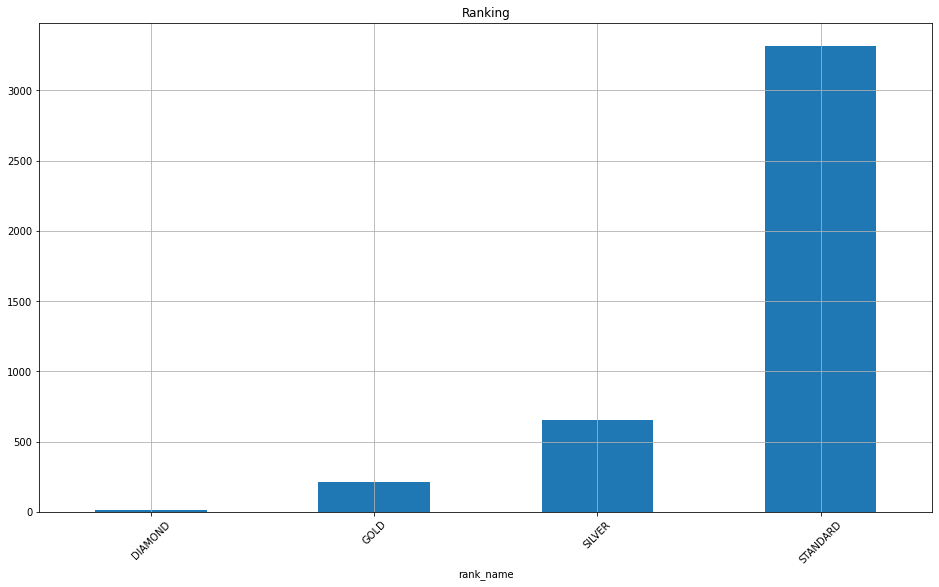

In [ ]:
loyalty_ranking.groupby('rank_name').User_id.nunique().plot(kind ='bar', figsize=(16,9), grid=True, title = 'Ranking', rot = 45)

______________________________________________________________________________

2/ Combined with the 'Loyalty benefits' table and 'Loyalty Ranking' table, add columns '%cashback'  in 'Transactions' table and calculate the total cashback cost in February 2022.								
"* Note: 
- Cashback cost can be calculated by multiplying %cashback with GMV
- User can only claim maximum of 10,000 VND per transaction"								

Merge to get the class ID for the new_trans table

In [ ]:
new_trans = pd.merge(new_trans,rules[['classID','rank_name']],on='rank_name', how='left')
benefits.rename(columns = {'Class ID': 'classID','Group':'service_group'},inplace=True)

- create a temp table by combining with new_trans and benefits to get the **%cashback** 
- modify cashback column name for the ease of query

In [ ]:
temp = pd.merge(new_trans,benefits,on=['classID','service_group'],how='left')
temp.rename(columns = {'%cashback':'cashback_per'},inplace=True)
temp.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,service_group,point,loyalty_points,rank_name,classID,cashback_per
0,2022-01-01,19502954801,Supermarket,25,45715492,41400,supermarket,41.4,41.4,STANDARD,1,NaN
1,2022-01-01,19492487660,CVS,28,41720789,205000,cvs,205.0,205.0,STANDARD,1,NaN
2,2022-01-01,19491373621,CVS,28,55200938,237000,cvs,237.0,237.0,STANDARD,1,NaN
3,2022-01-01,19485025779,CVS,28,17144057,17000,cvs,17.0,17.0,STANDARD,1,NaN
4,2022-01-01,19497349350,Marketplace,37,46410460,340000,marketplace,340.0,340.0,STANDARD,1,NaN


Fill NaN cashback with 0 

In [ ]:
temp.cashback_per.fillna(0,inplace=True)

Get cashback percentage amount 

In [ ]:
temp.cashback_per = temp.cashback_per / 100

Calculate the cashback per trans, and check up if there's any invalid cahsback( cashback > 10000) 

In [ ]:
cashback = temp.cashback_per * temp.GMV
(cashback > 10 ** 4).sum()

787

Normalize the invalid cashback by assigning it to 10000 by default

In [ ]:
cashback = cashback.apply(lambda x: 10000 if x > 10000 else x)

In [ ]:
cashback.shape

(18813,)

Create cashback column in transaction table

In [ ]:
new_trans['cashback'] = cashback
new_trans.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,service_group,point,loyalty_points,rank_name,classID,cashback
0,2022-01-01,19502954801,Supermarket,25,45715492,41400,supermarket,41.4,41.4,STANDARD,1,0.0
1,2022-01-01,19492487660,CVS,28,41720789,205000,cvs,205.0,205.0,STANDARD,1,0.0
2,2022-01-01,19491373621,CVS,28,55200938,237000,cvs,237.0,237.0,STANDARD,1,0.0
3,2022-01-01,19485025779,CVS,28,17144057,17000,cvs,17.0,17.0,STANDARD,1,0.0
4,2022-01-01,19497349350,Marketplace,37,46410460,340000,marketplace,340.0,340.0,STANDARD,1,0.0


We can plot it on histogram to see the distribution of cashback

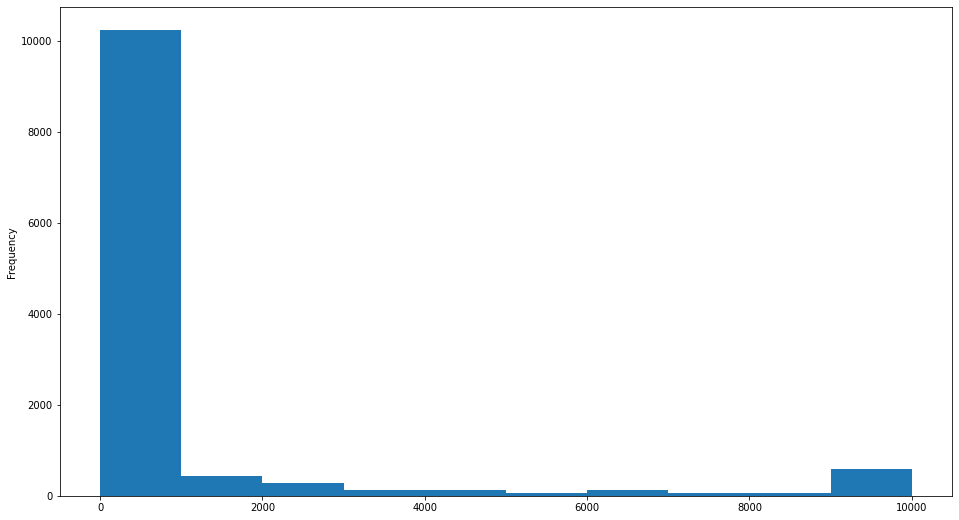

In [ ]:
cashback_in_feb = new_trans.query("DATE < '2022-03-01'").cashback
cashback_in_feb.plot(kind='hist', figsize=(16,9))

- We can see that, 0 cashback takes account for most of the distribution, makes our distribution very skew towards the inbalance. This is obvious since Standard user have the most amount among the categories, hence they have zero cashback
- We want to check how the distribution looks like for the remainder

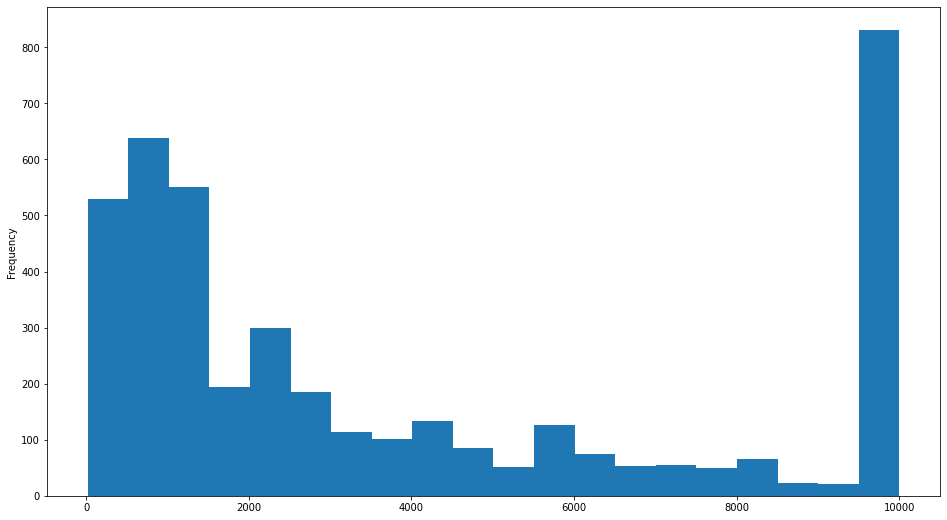

In [ ]:
temp_cashback = new_trans[new_trans.cashback > 0].cashback
temp_cashback.plot(kind='hist',figsize=(16,9), bins = 20)

_______________________________________________________________________________

**3/	Design a weekly retention charts of since the program was lauched to monitor**

Get the first date of service use for each user

In [ ]:
from datetime import datetime
new_trans['DATE'] = pd.to_datetime(new_trans['DATE'], errors ='coerce')
start_date = new_trans.groupby(['User_id']).DATE.min()
start_date.rename('start_day',inplace=True)
start_date.head()

User_id
136825   2022-01-24
162483   2022-03-23
199215   2022-01-28
298202   2022-02-15
321062   2022-03-25
Name: start_day, dtype: datetime64[ns]

Merge to the new DataFrame called retention_df

In [ ]:
retention_df = pd.merge(new_trans, start_date, on='User_id',how='left')
retention_df.head()

,DATE,Order_id,NEWVERTICAL_Merchant,MerchantID,User_id,GMV,service_group,point,loyalty_points,rank_name,classID,cashback,start_day
0,2022-01-01,19502954801,Supermarket,25,45715492,41400,supermarket,41.4,41.4,STANDARD,1,0.0,2022-01-01
1,2022-01-01,19492487660,CVS,28,41720789,205000,cvs,205.0,205.0,STANDARD,1,0.0,2022-01-01
2,2022-01-01,19491373621,CVS,28,55200938,237000,cvs,237.0,237.0,STANDARD,1,0.0,2022-01-01
3,2022-01-01,19485025779,CVS,28,17144057,17000,cvs,17.0,17.0,STANDARD,1,0.0,2022-01-01
4,2022-01-01,19497349350,Marketplace,37,46410460,340000,marketplace,340.0,340.0,STANDARD,1,0.0,2022-01-01


In [ ]:
used_cols = ['DATE','User_id','start_day']
retention_df = retention_df[used_cols]

Extract start week and number of weeks since start week

In [ ]:
retention_df['days_since_start'] = (retention_df['DATE'] - retention_df['start_day']).dt.days
# Extract start week
retention_df['start_week'] = retention_df.apply(lambda x: (x['start_day'] - pd.Timedelta(x['start_day'].dayofweek, u='day')).date(), axis=1)
retention_df['start_week'] = pd.to_datetime(retention_df['start_week'])

# Get the number of weeks since the user started
retention_df['weeks_since_start'] = np.floor((retention_df['DATE'] - retention_df['start_week']) / np.timedelta64(1, 'W'))

In [ ]:
retention_df.head()

,DATE,User_id,start_day,days_since_start,start_week,weeks_since_start
0,2022-01-01,45715492,2022-01-01,0,2021-12-31,0.0
1,2022-01-01,41720789,2022-01-01,0,2021-12-31,0.0
2,2022-01-01,55200938,2022-01-01,0,2021-12-31,0.0
3,2022-01-01,17144057,2022-01-01,0,2021-12-31,0.0
4,2022-01-01,46410460,2022-01-01,0,2021-12-31,0.0


Get unique number of weeks since start week 

In [ ]:
retention_df['weeks_since_start'] = retention_df['weeks_since_start'].astype(int)
weeks_since_start = retention_df.groupby('weeks_since_start').User_id.nunique()
weeks_since_start.head()

weeks_since_start
0    3358
1     799
2     644
3     539
4     517
Name: User_id, dtype: int64

We can see there's a huge drop from the 1st week to the 2nd week

In [ ]:
per_back_active = weeks_since_start.loc[1]/weeks_since_start.loc[0]*100
print(f'There is {per_back_active:.2f}% user active on 2nd week after used the service on the first week')

There is 23.79% user active on 2nd week after used the service on the first week


Get the percentage of active users per total users

In [ ]:
retention_series = weeks_since_start / weeks_since_start.loc[0]*100
retention_series.head()

weeks_since_start
0    100.000000
1     23.793925
2     19.178082
3     16.051221
4     15.396069
Name: User_id, dtype: float64

Plot the Weekly Retention

Text(0, 0.5, 'Percent Of Users Retained(%)')

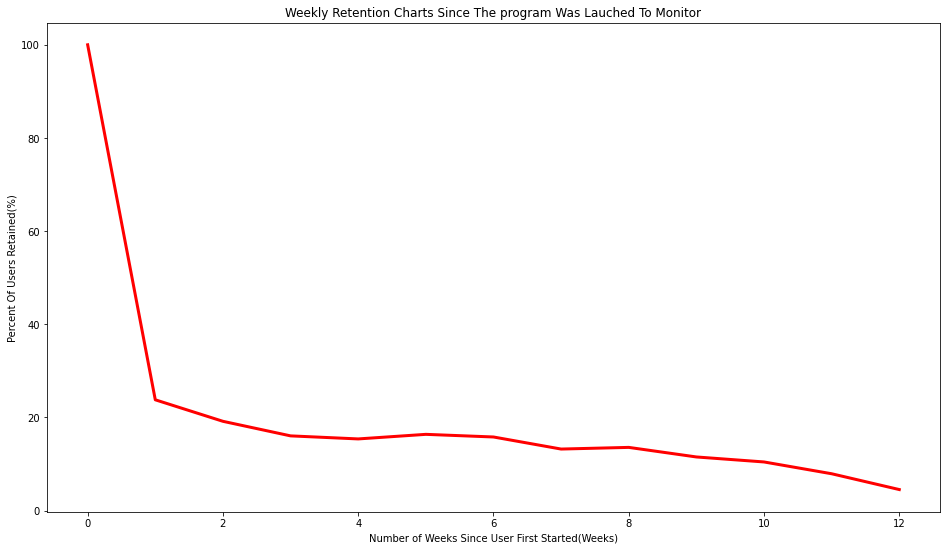

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(retention_series, color = 'red', linewidth= 3)
plt.title("Weekly Retention Charts Since The program Was Lauched To Monitor")
plt.xlabel("Number of Weeks Since User First Started(Weeks)")
plt.ylabel("Percent Of Users Retained(%)")


#**Part 2: Analyze and Comment**

Based on data above, give your opinion about:		

1/	User retention and transaction behavior (Is there any trend?) since Loyalty program launched. Do you have any advice for the Marketing department in designing promotion campaigns to increase user retention's performance monthly?											

- From the retention rate report, we can easily see that the trend is a downline from week 0 to week 1. This trend could seem to be dramatic at first, but it actually is understandable as almost every retention rate could have a model like that from week 0 to week 1
- To the next several weeks, it has a little plateau period for **2-3 weeks** then gradually decrease overtime
- The final rate could be alarming as it has already reach around **6%** retention rate


We want to explore that what the proportion of the service groups is, in order to delve more into transaction behavior

Check proportion of service group before being launched

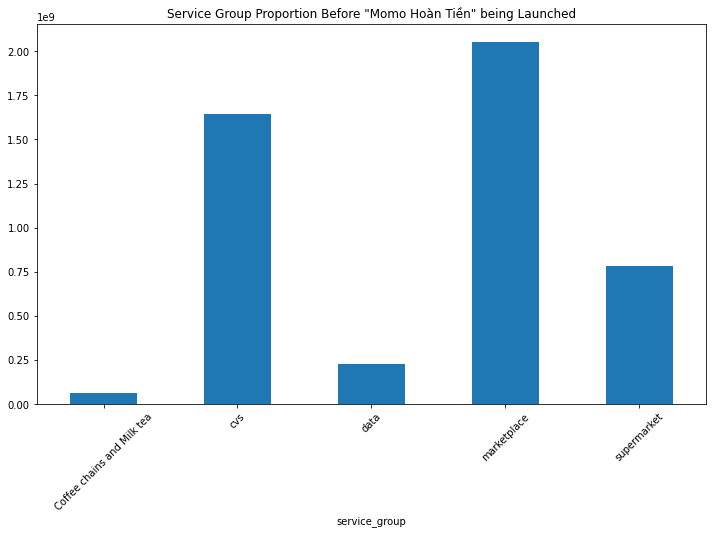

In [ ]:
trans_before_launched = trans.query("DATE < '2022-01-01'")
trans_before_launched.groupby('service_group').GMV.sum().plot(kind='bar',rot=45, figsize=(12,7),title='Service Group Proportion Before "Momo Hoàn Tiền" being Launched')

Compare proportion of service group beofre and  after being launched

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2462dd2090>,
      dtype=object)

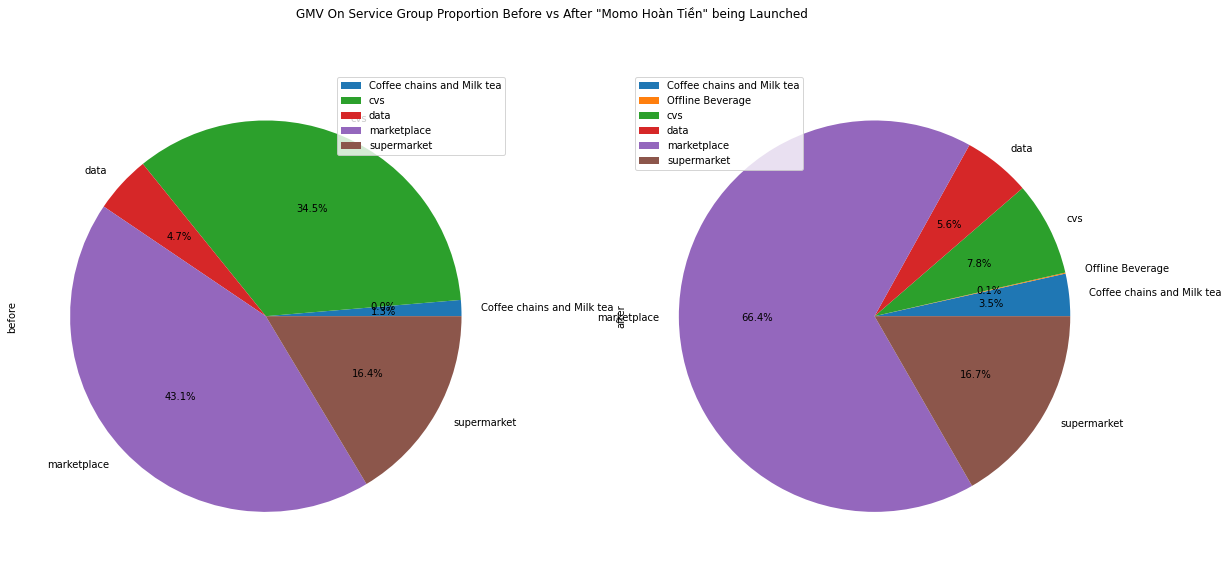

In [ ]:
pair_trans = pd.DataFrame(columns=['before','after'])
pair_trans['after'] = new_trans.groupby('service_group').GMV.sum()
pair_trans['before'] = trans_before_launched.groupby('service_group').GMV.sum()
pair_trans.fillna(0)
pair_trans.plot(kind='pie',subplots=True,figsize=(20,9),
                autopct='%1.1f%%',
                title='GMV On Service Group Proportion Before vs After "Momo Hoàn Tiền" being Launched')

- Before Launched, most of the GMV were divided approximately equally between 2 big Service Group: Marketplace and CVS. To be exact, Marketplace proportion were slightly larger than CVS by about 9%
- After Launched, the proportion has shifted dramatically, customers tend to use the service for marketplace with a fraction of 66.4%. On the otherside, CVS has fallen from 34.5% to 7.8%


Check which Merchant has the largest volume using Momo payment

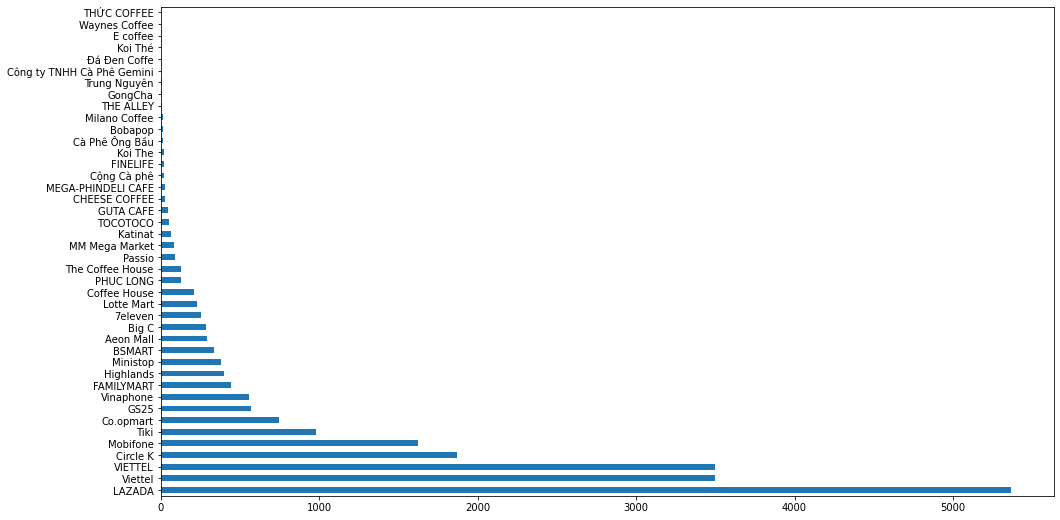

In [ ]:
sub_merchant_df = pd.merge(new_trans,merchant,on=['MerchantID','service_group'],how='left')[['Order_id','MerchantID','service_group','Merchant']].drop_duplicates(ignore_index=True)
sub_merchant_df.Merchant.value_counts().plot(kind='barh',figsize=(16,9))

Check Total GMV Per Day 

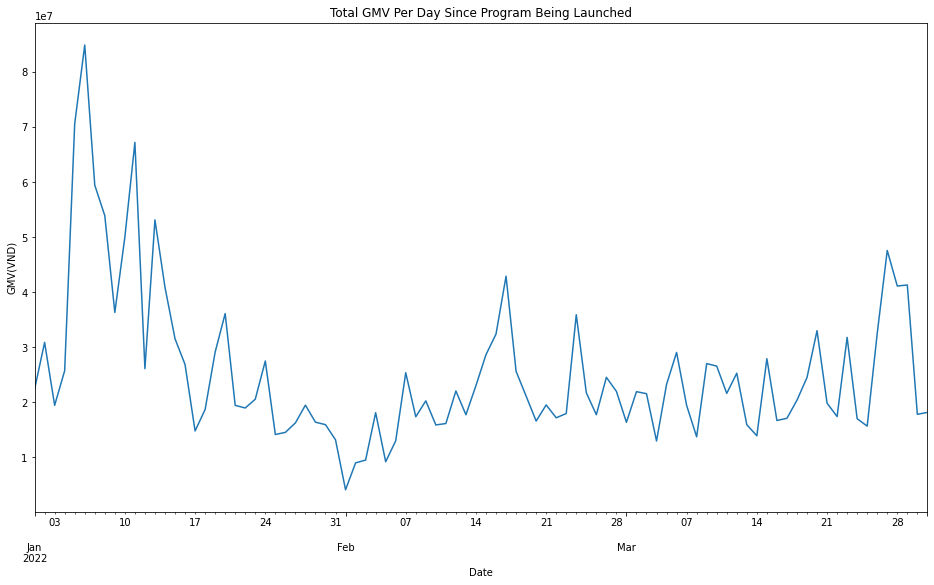

In [ ]:
new_trans.groupby(['DATE']).GMV.sum().plot(figsize=(16,9), xlabel='Date', ylabel ='GMV(VND)', title = 'Total GMV Per Day Since Program Being Launched')


- Based on the given data, most of the retention value is contributed from Diamond and Gold customer. 
- Hence, we can target the Standard ranking user by several marketing strategy such as in-app marketing and conduct survey to explore the hidden cause. On the otherside, we want to keep rewarding our Gold and Diamond user
- Marketplace has been the most profitable platform, we can execute several promotion that keep user using Momo when they checkout on Marketplace
- Offline Beverage could be a potential platform because this can be counted as one of the daily neccesary, hence increasing our retention rate. We can push this process faster by **SEO** and **Influencer marketing campaign.** 
- CVS has been dropped dramatically, so we want to conduct some survey to figure out the reason and then modify 
- Focus more on philosophy user-centric





________________________________________________________________________________

2/	Momo is facing increasing amount of cashback cost as well as  GMV since launched. However, we want to optimize the cost but still want to keep growth of GMV and increase the retention rate.  Based on data given, please propose ideas to change the schemes of Loyalty benefits and Loyalty Points to alleviate the cost amount.																

- Lower the maximum point that can be earn for Marketplace. Since Marketplace has been the most group's GMV, this one can cause the loyalty points escalating easily
- Slightly increase point mechanism for  Offline Beverage and Coffe/Milktea group 
- We can keep the current cashback mechanism scheme for now to attract more user and improve the retention rate or slightly lower cashback rate for marketplace and supermarket. Then we can lower each cashback rate for each service group depends on its growth, especally on Offline Beverage, CVS and data

#**Part 3: Extended question**

2/ Gamification is usually a sensible option for apps to raise users’ stickiness. In our loyalty program development strategy, we also plan to hold a small game for users. The rule is simple: any users who can maintain a 20-day or longer streak of being in the DIAMOND ranking is a winner (in other words, winners are users who have total loyalty points greater than or equal to 5,000 for at least 20 consecutive days). We also want to give a special reward for the user(s) who can maintain the longest streak. Could you help us to calculate how many winners were there during the last thirty days in the given data (March 01 - March 31) and who was/were the one(s) boasting the longest streak during that time?										
										
										
										

In [ ]:
#Get needed columns to get the ultimate results
added_cols = ['DATE','User_id','point','loyalty_points','rank_name'] 
test_df = new_trans.copy()[added_cols]
test_df['prev_loy_points'] = test_df.groupby(['User_id']).loyalty_points.shift(1) #loyalty point of the previous trans record of user
test_df['not_diamond_b4'] = test_df['prev_loy_points'] >= 5000 #bool columns to check if the user has already a DIAMOND ranking
test_df['prev_date'] = test_df.groupby(['User_id']).DATE.shift(1) #date of previous trans record of user
test_df['time_range'] = test_df['DATE'] - test_df['prev_date'] #time different between the previous transaction and the current transaction

In [ ]:
test_df.query("rank_name == 'DIAMOND'") #get all the diamond user transaction record

,DATE,User_id,point,loyalty_points,rank_name,prev_loy_points,not_diamond_b4,prev_date,time_range
1189,2022-01-05,50469826,1000.0,5000.00,DIAMOND,4000.0,False,2022-01-05,0 days
1197,2022-01-05,50469826,1000.0,6000.00,DIAMOND,5000.0,True,2022-01-05,0 days
1209,2022-01-06,50185392,500.0,7578.00,DIAMOND,3600.0,False,2022-01-05,1 days
1211,2022-01-06,50185392,500.0,7078.00,DIAMOND,7578.0,True,2022-01-06,0 days
1214,2022-01-06,50185392,500.0,6578.00,DIAMOND,7078.0,True,2022-01-06,0 days
...,...,...,...,...,...,...,...,...,...
18680,2022-03-31,47662326,500.0,21353.32,DIAMOND,21713.1,True,2022-03-29,2 days
18760,2022-03-31,49689927,100.0,9000.00,DIAMOND,8700.0,True,2022-03-30,1 days
18785,2022-03-31,49689927,100.0,8800.00,DIAMOND,9000.0,True,2022-03-31,0 days
18795,2022-03-31,49689927,100.0,8900.00,DIAMOND,8800.0,True,2022-03-31,0 days


In [ ]:
def get_streak(df,user_id):
  user_df = df[df.User_id == user_id]
  streaks = []
  dates = []

  #Loop thru the df to get the streak of the particular user for each transaction
  for i,row in user_df.iterrows():
    check = row['not_diamond_b4']
    cur_date = row['DATE']
    prev_date = row['prev_date']
    time_range = row['time_range']
    
    if check:
      streak = time_range + streaks[-1]
      streaks.append(streak)

    else:
      streaks.append(pd.to_timedelta('0'))

    dates.append(cur_date)
  
  n = len(dates)
  user = [user_id]*n
  new_df = pd.DataFrame(list(zip(dates,user,streaks)), columns = ['DATE','User_id','Streak'])

  #Return the dataframe that contains streak for each transaction per user_id
  return new_df


In [ ]:
test_df_diamond = test_df.query("rank_name == 'DIAMOND'")

#Create new dataframe, and loop thru each unique user_id to get the repsective streak for its transaction record
diamond_users = list(test_df_diamond['User_id'].unique())
diamond_streaks_df = pd.DataFrame(columns = ['DATE','User_id','Streak'])

for user_id in diamond_users:
  new_df = get_streak(test_df_diamond,user_id)
  diamond_streaks_df = pd.concat([diamond_streaks_df,new_df],ignore_index = True)

diamond_streaks_df.head()

,DATE,User_id,Streak
0,2022-01-05,50469826,0 days
1,2022-01-05,50469826,0 days
2,2022-01-06,50185392,0 days
3,2022-01-06,50185392,0 days
4,2022-01-06,50185392,0 days


**Filter out diamond user who has 20 days streak**

In [ ]:
diamond_20streak_df= diamond_streaks_df[diamond_streaks_df.Streak >= pd.to_timedelta('20D')]
diamond_20streak_df.head()

,DATE,User_id,Streak
64,2022-01-30,50185392,21 days
65,2022-01-30,50185392,21 days
66,2022-02-06,50185392,28 days
67,2022-02-06,50185392,28 days
68,2022-02-06,50185392,28 days


**List of User ID that has 20 streaks**

In [ ]:
top_users = list(diamond_20streak_df.User_id.unique())
for user in top_users:
  print(user, end ='  ')

50185392  54960619  47662326  39956101  55200938  57207697  39314846  51432947  

**The User ID that has the longeest streak and receive a special reward**

In [ ]:
diamond_20streak_df.loc[diamond_20streak_df.Streak.idxmax(),'User_id']

47662326

**Filter out the number winners in last 30 days**

In [ ]:
diamond_20_last_30days = diamond_20streak_df.query("DATE > '2022-02-28'")
diamond_20_last_30days.User_id.nunique()

6

**Winner that have longest streak during last 30 days**

In [ ]:
diamond_20_last_30days.loc[diamond_20_last_30days.Streak.idxmax(),'User_id']

47662326